# IO. Práctica 2, Parte 1 -> Política óptima para circuitos

## Dinámica del Entrenamiento: Control Monte Carlo

Este proyecto implementa un agente de Aprendizaje por Refuerzo (RL) utilizando el método **Control Monte Carlo On-Policy**. A continuación se detalla la física del entorno, el proceso de toma de decisiones y el algoritmo de aprendizaje.

---

### 1. Física y Acciones del Vehículo

El coche no se mueve de forma arbitraria. Sigue un modelo físico discreto con inercia.

#### - El Estado ($S_t$)
En cada instante temporal $t$, el estado del vehículo se define por una tupla de 4 variables:
$$S_t = (x_t, y_t, v_{x,t}, v_{y,t})$$
Donde $(x, y)$ es la posición en la matriz y $(v_x, v_y)$ es la velocidad actual.

#### - La Acción ($A_t$)
El agente no elige la posición, sino la aceleración. En cada paso, selecciona una modificación para la velocidad:
$$A_t = (\Delta v_x, \Delta v_y) \quad \text{donde} \quad \Delta v \in \{-1, 0, +1\}$$
Esto nos da un total de **9 acciones posibles** (combinaciones de frenar, mantener o acelerar en cada eje).

#### - Transición de Estado
Una vez elegida la acción, el entorno calcula el siguiente estado $S_{t+1}$ en dos pasos:

1.  **Actualización de Velocidad:** Se suma la aceleración a la velocidad actual y se limita al rango permitido $[0, 4]$:
    $$v_{x, t+1} = \text{clip}(v_{x,t} + \Delta v_x, 0, 4)$$
    $$v_{y, t+1} = \text{clip}(v_{y,t} + \Delta v_y, 0, 4)$$

2.  **Actualización de Posición:** La nueva posición es la suma vectorial de la posición anterior y la nueva velocidad:
    $$P_{t+1} = P_t + V_{t+1}$$


#### - Detección de Colisiones: Verificación de Trayectoria (Ray-Casting)

Uno de los desafíos en un entorno de cuadrícula (grid world) con velocidades altas es que, si el coche se mueve de la casilla $A$ a la casilla $B$ en un solo paso porque tiene mucha velocidad, podría "saltarse" un muro que hubiera en medio.

Para evitar esto, no basta con mirar el punto final. Implementamos un algoritmo de trazado de rayos (similar al *Algoritmo de Bresenham* o Interpolación Lineal) para verificar cada casilla por la que pasa el vehículo.

Supongamos que el coche se mueve desde una posición inicial $P_0=(x_0, y_0)$ hasta una posición final $P_1=(x_1, y_1)$.

1.  **Cálculo de la Resolución:** Determinamos cuántos puntos intermedios debemos revisar. Para asegurar que no nos saltamos ninguna celda, tomamos la distancia máxima en cualquiera de los ejes:
    $$N = \max(|x_1 - x_0|, |y_1 - y_0|) + 1$$
    Donde $N$ es el número de pasos de verificación.

2.  **Ecuación de la Recta:** Parametrizamos la trayectoria con una variable $t$ que va de $0$ a $1$. Para cada paso $i$ (desde 1 hasta $N$):
    $$t = \frac{i}{N}$$

    La coordenada exacta del punto intermedio se calcula como:
    $$x_i = x_0 + t \cdot (x_1 - x_0)$$
    $$y_i = y_0 + t \cdot (y_1 - y_0)$$

3.  **Discretización:** Como el mapa es una matriz de enteros, redondeamos las coordenadas al entero más cercano para saber en qué casilla cae ese punto de la trayectoria:
    $$Casilla_{verificar} = (\text{round}(x_i), \text{round}(y_i))$$

#### Lógica de Decisión
En cada paso $i$ del bucle, el algoritmo comprueba el valor de la matriz en esa $Casilla_{verificar}$:
* Si encuentra un **1 (#)**: Se declara **Choque**. El movimiento se cancela inmediatamente y el coche se resetea.
* Si encuentra un **3 (F)**: Se declara **Meta**. El episodio termina con éxito.
* Si es **0 (.)**: Continúa verificando el siguiente punto hasta llegar al destino.

---

### 2. Agente Monte Carlo

El agente no conoce el mapa ni la física. Aprende exclusivamente a base de experiencia empírica (ensayo y error).

#### Toma de Decisiones: Política $\epsilon$-Greedy
Para decidir qué acción tomar en el estado $S$, el agente utiliza una política que equilibra la exploración y la explotación:

$$
\pi(a|s) = 
\begin{cases} 
\text{Acción Aleatoria} & \text{con probabilidad } \epsilon \quad \text{(Exploración)} \\
\arg\max_{a} Q(s, a) & \text{con probabilidad } 1 - \epsilon \quad \text{(Explotación)}
\end{cases}
$$

* **Exploración:** Permite descubrir nuevas rutas o atajos que el agente aún no conoce.
* **Explotación:** Elige la acción que, según su memoria (Tabla Q), ha dado mejores resultados en el pasado.

#### El Aprendizaje: Actualización de la Tabla Q
El algoritmo Monte Carlo no aprende paso a paso, sino episodio a episodio.
1.  El agente completa una carrera (o choca/termina por tiempo).
2.  Calcula el **Retorno ($G$)** obtenido, que es la suma de recompensas desde ese punto hasta el final:
    $$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots$$
3.  **Propagación hacia atrás:** Recorre el historial del episodio inversamente y actualiza el valor $Q(S, A)$ de cada par estado-acción visitado usando la media incremental:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{1}{N(S_t, A_t)} (G_t - Q(S_t, A_t))$$

**Efecto en el futuro:** Si una secuencia de acciones lleva a la meta rápidamente, el valor $G$ será alto (menos negativo). Esto aumenta el valor $Q$ de esas acciones. La próxima vez que el coche pase por ese estado, la opción `arg_max` elegirá esa acción ganadora.

---

### 3. Organización del Entrenamiento

El proceso global sigue un bucle estructurado:

1.  **Inicio del Episodio:** El coche se coloca en una posición aleatoria de la Salida ('S') con velocidad 0.
2.  **Bucle de Interacción:**
    * El agente observa $S_t$ y elige $A_t$.
    * El entorno devuelve $R_{t+1}$ y $S_{t+1}$.
    * Si hay **Choque**: El coche vuelve a la salida (penalización de tiempo), pero el episodio continúa aprendiendo.
3.  **Fin del Episodio:** Ocurre cuando el coche cruza la Meta ('F') o se supera el límite de pasos (`MAX_STEPS`).
4.  **Actualización:** Solo al terminar, el agente reflexiona sobre lo ocurrido y actualiza su Tabla Q.
5.  **Repetición:** Se repite el proceso $N$ veces (episodios). Con cada iteración, $\epsilon$ disminuye, haciendo al agente más preciso y menos aleatorio.

Importaciones

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Nuestras clases
from racetrack_env import RaceTrackEnv
from mc_agent import MonteCarloAgent
from racetrack_utils import train_agent, create_animation, show_track_layouts, create_static_trajectory_image

%matplotlib inline

Creamos los mapas con los que haremos las pruebas.


In [2]:
# Circuito 1: La "L" (Izquierda)
TRACK_LEFT = [
    "##################",
    "####.............F",
    "###..............F",
    "###..............F",
    "##...............F",
    "#................F",
    "#................F",
    "#..........#######",
    "#.........########",
    "#.........########",
    "#.........########",
    "#.........########",
    "#.........########",
    "#.........########",
    "#.........########",
    "##........########",
    "##........########",
    "##........########",
    "##........########",
    "##........########",
    "##........########",
    "##........########",
    "##........########",
    "###.......########",
    "###.......########",
    "###.......########",
    "###.......########",
    "###.......########",
    "###.......########",
    "###.......########",
    "####......########",
    "####......########",
    "####SSSSSS########"
]

# Circuito 2: La "S" (Derecha) - ¡NUEVO!
TRACK_RIGHT = [
    "####################################",
    "#################..................F",
    "##############.....................F",
    "#############......................F",
    "############.......................F",
    "############.......................F",
    "############.......................F",
    "############.......................F",
    "#############......................F",
    "##############.....................F",
    "###############...................##",
    "###############................#####",
    "###############...............######",
    "###############.............########",
    "##############.............#########",
    "#############..............#########",
    "############...............#########",
    "###########................#########",
    "##########.................#########",
    "#########..................#########",
    "########...................#########",
    "#######....................#########",
    "######.....................#########",
    "#####......................#########",
    "####.......................#########",
    "###........................#########",
    "##.........................#########",
    "#..........................#########",
    "#..........................#########",
    "#SSSSSSSSSSSSSSSSSSSSSSSSSS#########",
]

Para ello primero creamos los objetos `RaceTrackEnv` y `MonteCarloAgent` de cada uno de los mapas.


- ENTORNO (racetrack_env.py): Simula la física de un coche con inercia en una cuadrícula discreta. Implementa las reglas establecidas con posición, velocidad, inicio, meta, choques y reinicios entre otras configuraciones.

- AGENTE (mc_agent.py): Implementa un algoritmo de control Monte Carlo. No conoce el mapa, solo aprende a base de prueba y error (episodios completos) actualizando la tabla Q de 5 dimensiones que estima el valor de cada aceleración en cada estado (posición + velocidad).

In [3]:
# Creamos los objetos con la física del experimento
env_left = RaceTrackEnv(TRACK_LEFT)
env_right = RaceTrackEnv(TRACK_RIGHT)

# Inicializamos agentes
agent_left = MonteCarloAgent(env_left)
agent_right = MonteCarloAgent(env_right)

Comprobamos la forma del mapa mediante una visualización más sencilla para nuestros ojos.

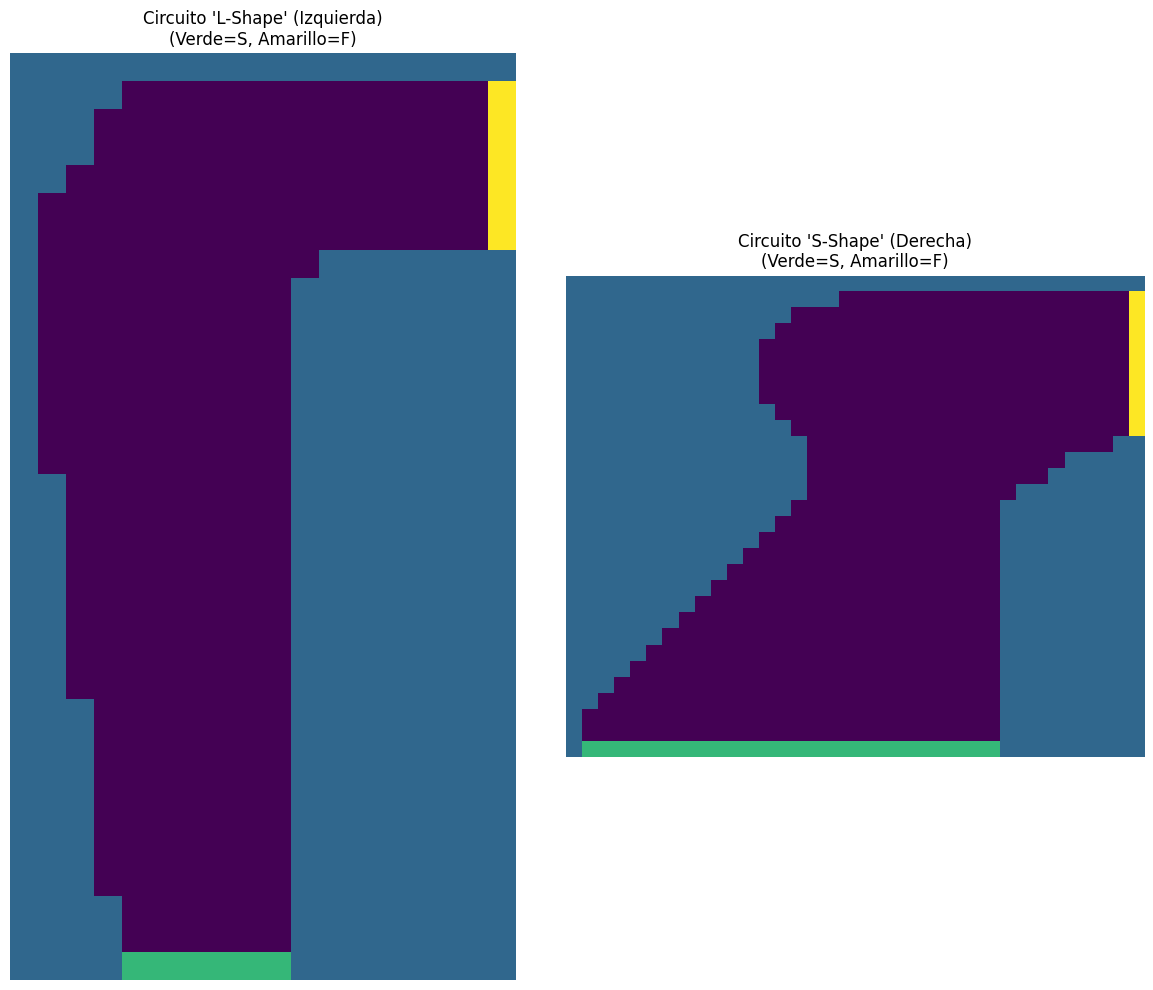

In [4]:
show_track_layouts(
    [env_left, env_right], 
    ["Circuito 'L-Shape' (Izquierda)", "Circuito 'S-Shape' (Derecha)"]
)

Entrenamiento:

- Se ejecutarán 10.000 episodios donde el agente interactúa con el entorno. Se utiliza una política e-greedy con decaimiento (explora mucho  al principio, poco al final) para garantizar la cvonvergencia a una ruta óptima.

Visualización:

- Vamos a generar dos gifs para ver la evolución de cómo aprende hasta completar el primer episodio, y luego otrro gif qwue resume los siguientes episodios de 500 en 500, así viendo una evolución global del entrenamiento.
- Creamos una imagen representando el camino final y viéndose de fondo los demás que fueron intentos.

In [5]:
# Configuración
EPISODIOS = 10000

# --- PISTA IZQUIERDA ---


# Entrenar
historia_left = train_agent(env_left, agent_left, num_episodes=EPISODIOS)

# Separamos datos
datos_novato_left = [h for h in historia_left if h['episode']==1]
datos_pro_left = [h for h in historia_left if h['episode']>1]


# GENERAR GIFs

create_animation(env_left, datos_novato_left, "track_left_novato.gif", title_prefix="L-TRACK NOVATO -")
create_animation(env_left, datos_pro_left, "track_left_pro.gif", title_prefix="L-TRACK PRO -")


# GENERAR IMAGENES DEL RECORRIDO FINAL

# Imagen del Novato (Episodio 1)
create_static_trajectory_image(env_left, datos_novato_left, 
                               "foto_finish_left_novato.png", title="L-Track: Resultado Episodio 1")

# Imagen del Pro (Último episodio registrado)
create_static_trajectory_image(env_left, datos_pro_left, 
                               "foto_finish_left_pro.png", title="L-Track: Ruta Óptima Aprendida")


# --- PISTA DERECHA ---


# Entrenar
historia_right = train_agent(env_right, agent_right, num_episodes=EPISODIOS)

# Separamos datos
datos_novato_right = [h for h in historia_right if h['episode']==1]
datos_pro_right = [h for h in historia_right if h['episode']>1]


# GENERAR GIFs

create_animation(env_right, datos_novato_right, "track_right_novato.gif", title_prefix="R-TRACK NOVATO -")
create_animation(env_right, datos_pro_right, "track_right_pro.gif", title_prefix="R-TRACK PRO -")


# GENERAR IMAGENES DEL RECORRIDO FINAL

# Imagen del Novato (Episodio 1)
create_static_trajectory_image(env_right, datos_novato_right, 
                               "foto_finish_right_novato.png", title="R-Track: Resultado Episodio 1")

# Imagen del Pro (Último episodio registrado)
create_static_trajectory_image(env_right, datos_pro_right, 
                               "foto_finish_right_pro.png", title="R-Track: Ruta Óptima Aprendida")

--- Iniciando entrenamiento en mapa 18x33 (10000 eps) ---
   > Progreso: 10% | Tiempo: 2s
   > Progreso: 20% | Tiempo: 3s
   > Progreso: 30% | Tiempo: 4s
   > Progreso: 40% | Tiempo: 5s
   > Progreso: 50% | Tiempo: 6s
   > Progreso: 60% | Tiempo: 7s
   > Progreso: 70% | Tiempo: 7s
   > Progreso: 80% | Tiempo: 8s
   > Progreso: 90% | Tiempo: 9s
   > Progreso: 100% | Tiempo: 9s
--- Entrenamiento finalizado en 9.3s ---

Generando GIF 'track_left_novato.gif'...
✅ GIF guardado: track_left_novato.gif
Generando GIF 'track_left_pro.gif'...
✅ GIF guardado: track_left_pro.gif
Generando imagen estática inteligente: foto_finish_left_novato.png...
✅ Imagen guardada: foto_finish_left_novato.png
Generando imagen estática inteligente: foto_finish_left_pro.png...
✅ Imagen guardada: foto_finish_left_pro.png
--- Iniciando entrenamiento en mapa 36x30 (10000 eps) ---
   > Progreso: 10% | Tiempo: 2s
   > Progreso: 20% | Tiempo: 3s
   > Progreso: 30% | Tiempo: 3s
   > Progreso: 40% | Tiempo: 4s
   > Progreso